In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from pylab import rcParams
from sklearn.model_selection import LeaveOneOut, KFold
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline
import scipy


import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

/Users/lingdai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lingdai/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Problem 1

In [68]:
# Read in strong drink data
sdrink = pd.read_csv('strongdrink.txt', sep=',', header = 0)
sdrink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [69]:
#check for missing data
sdrink.isnull().sum()

cultivar      0
alco          0
malic         0
ash           0
alk           0
magn          0
tot_phen      0
flav          0
nonfl_phen    0
proanth       0
color_int     0
hue           0
OD280rat      0
proline       0
dtype: int64

## 1(a)

In [96]:
import statsmodels.api as sm

X = sdrink[['alco', 'malic', 'tot_phen', 'color_int']]
X = sm.add_constant(X)
y = sdrink[['cultivar']]

# This function train_test_split is from sklearn.cross_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    random_state=20)

MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg.fit(X_train, y_train)

y_pred = MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



/Users/lingdai/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The error rate for class 1 is 1 - 0.87 = 0.13.

The error rate for class 2 is 1 - 1 = 0.

The error rate for class 3 is 1 - 1 = 0.

According to the results above, the model is best at predicting class 2 and 3.

In [97]:
#Number of observations for each class
sdrink.cultivar.value_counts().sort_index()

1    59
2    71
3    46
Name: cultivar, dtype: int64

The most accurately predicted class is indeed the class with most observations.

## 1(b)

In [135]:
#leave-one-out cross validation (LOOCV)

from sklearn.model_selection import LeaveOneOut

Xvals = X.values
yvals = y.values

N_loo = Xvals.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvals)
MSE_vec = np.zeros(N_loo)
y_test_vec = np.zeros(N_loo)
y_pred_vec = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    MultLogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    MultLogReg.fit(X_train, y_train)
    y_pred = MultLogReg.predict(X_test)
    MSE_vec[test_index] = (y_test - y_pred) ** 2
    y_pred_vec[test_index] = y_pred
    y_test_vec[test_index] = y_test
    
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('\ntest estimate MSE loocv=', MSE_loo,
      '\ntest estimate MSE standard err=', MSE_loo_std)

/Users/lingdai/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



test estimate MSE loocv= 0.09659090909090909 
test estimate MSE standard err= 0.39426250589387657


In [133]:
print(classification_report(y_test_vec, y_pred_vec))

             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



The error rate for class 1 is 1 - 0.90 = 0.10.

The error rate for class 2 is 1 - 0.91 = 0.09.

The error rate for class 3 is 1 - 0.96 = 0.04.

Compared to the error rates of multinomial logistic regression from (a), we can see that the error rates of LOOCV are higher for class 2 and 3, but lower for class 1. Overall, the average error rate of LOOCV (0.8) is higher compared to the average error rate of multinomial logistic regression (0.4).

## 1(c)

In [130]:
from sklearn.model_selection import KFold
k=4
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(Xvals)

4

In [134]:
y_test_vec = np.zeros(N_loo)
y_pred_vec = np.zeros(N_loo)

MSE_vec_kf = np.zeros(k)

k_ind = int(0)
for train_index, test_index in kf.split(Xvals):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    y_pred_vec[test_index] = y_pred
    y_test_vec[test_index] = y_test.flatten()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('\ntest estimate MSE k-fold=', MSE_kf,
      '\ntest estimate MSE standard err=', MSE_kf_std)

k index= 0
MSE for test set 0  is 1.012396694214876
k index= 1
MSE for test set 1  is 1.3233471074380165
k index= 2
MSE for test set 2  is 1.1818181818181819
k index= 3
MSE for test set 3  is 1.0537190082644627

test estimate MSE k-fold= 1.1428202479338843 
test estimate MSE standard err= 0.12151143991924328


/Users/lingdai/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [126]:
print(classification_report(y_test_vec, y_pred_vec))

             precision    recall  f1-score   support

        1.0       0.81      0.75      0.78        59
        2.0       0.81      0.87      0.84        71
        3.0       0.96      0.93      0.95        46

avg / total       0.85      0.85      0.85       176



The error rate for class 1 is 1 - 0.81 = 0.19.

The error rate for class 2 is 1 - 0.81 = 0.19.

The error rate for class 3 is 1 - 0.96 = 0.04.

Compared to the results from (a) and (b), we can see that the error rates of k-fold cross validation are higher.

# Problem 2

In [2]:
#Import data
cool = pd.read_csv('CoolIndex.txt', sep=',', names = ['age','coolness'])
cool.head()

,age,coolness
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


## 2(a)

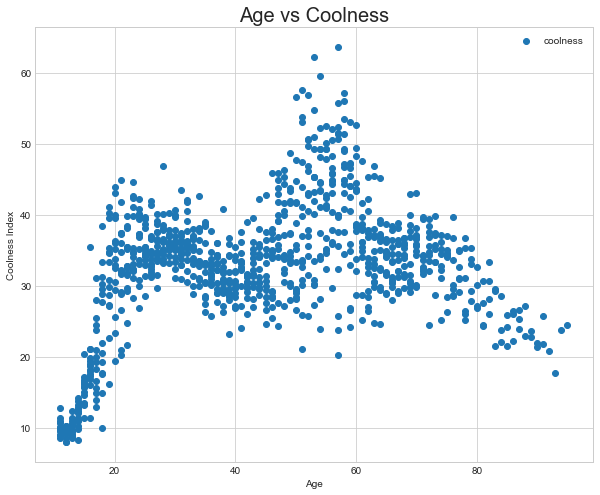

In [41]:
import matplotlib.pyplot as plt

coolness = cool['coolness']
age = cool['age']

plt.title('Age vs Coolness', fontsize = 20)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.scatter(age, coolness)
plt.legend()

## 2(b)

In [42]:
# Use OLS to fit a stepwise function
age_bin1 = (age < 22).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = (age >= 77).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))
X_step.describe()

,age_bin1,age_bin2,age_bin3,age_bin4,age_bin5
count,956.000000,956.000000,956.000000,956.000000,956.000000
mean,0.162134,0.276151,0.285565,0.217573,0.058577
std,0.368767,0.447326,0.451919,0.412812,0.234955
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
#Fit OLS linear regression model

import statsmodels.api as sm

reg1 = sm.OLS(endog=cool['coolness'], exog=X_step, missing='drop')
results = reg1.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Sun, 18 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        21:08:50   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

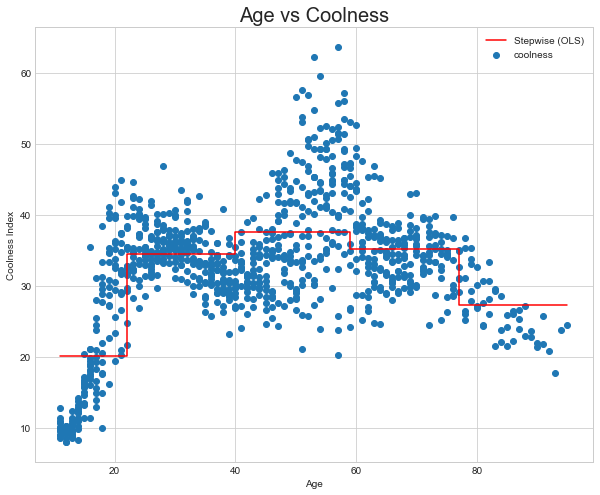

In [44]:
#Plot stepwise function
import matplotlib.pyplot as plt

x = [min(age),22,40,59,77,max(age)]
y = results.params.tolist() + [results.params[-1]]

plt.title('Age vs Coolness', fontsize = 20)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.scatter(age, coolness)
plt.step(x, y, color = 'red', where = 'post', label = "Stepwise (OLS)")
plt.legend()

According to the regression results above, $\beta_1 = 20.1025$, $\beta_2 = 34.4758$, $\beta_3 = 37.6351$, $\beta_4 = 35.2254$, and $\beta_5 = 27.2964$. Because a 73-year old person will fall into age_bin4, the predicted coolness of the person will be 35.2254.

# 2(c)

In [50]:
test_add = np.linspace(0, 1e-10, len(age))

In [60]:
# Fit linear spline
knots = [22, 40, 59, 77]
k = 1
test_age = age + test_add

linear_spl = LSQUnivariateSpline(test_age.values, coolness.values, t=knots, k=1)

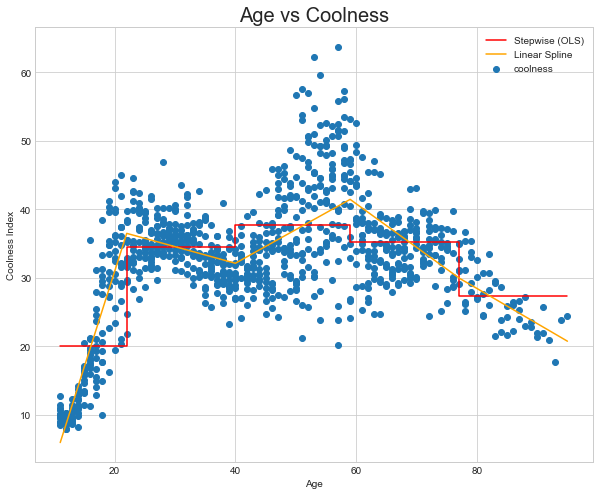

In [61]:
# Plot fitted spline curve
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

plt.title('Age vs Coolness', fontsize = 20)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.scatter(age, coolness)
plt.step(x, y, color = 'red', where = 'post', label = "Stepwise (OLS)")
plt.plot(age_vec, linear_spl(age_vec), 'orange', label = 'Linear Spline')
plt.legend()

In [62]:
linear_spl(np.array([73]))

array([32.53683239])

The predicted coolness of a 73-year old is 32.53683239.

## 2(d)

In [55]:
#Fit cubic spline

cubic_spl = LSQUnivariateSpline(test_age.values, cool.coolness.values, t = knots, k = 3)

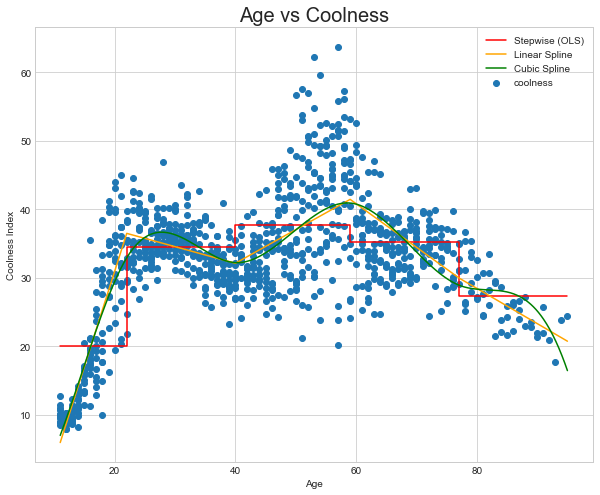

In [56]:
# Plot fitted cubic spline curve
plt.title('Age vs Coolness', fontsize = 20)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.scatter(age, coolness)
plt.step(x, y, color = 'red', where = 'post', label = "Stepwise (OLS)")
plt.plot(age_vec, linear_spl(age_vec), 'orange', label = 'Linear Spline')
plt.plot(age_vec, cubic_spl(age_vec), 'green', label = 'Cubic Spline')
plt.legend()

In [63]:
cubic_spl(np.array([73]))

array([31.26242939])

The predicted coolness of a 73-year old is 31.26242939.